In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Audio_Sentiment_Analysis/iemocap/data

Mounted at /content/drive
/content/drive/MyDrive/Audio_Sentiment_Analysis/iemocap/data


In [ ]:
import sys
import os
# go to upper diretory
sys.path.append(os.path.abspath('./../../../'))
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier as RandomForest, RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, KFold
from Audio_Sentiment_Analysis.utils.Configuration import Configuration
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
AUDIO_DIR = f"{os.path.abspath('./../../../')}/IEMOCAP_Dataset"
EXTRACTED_FEATURES_FILE = 'extracted_features_iemocap.csv'
CONFIG_FILE = f"{os.path.abspath('./../../../')}/Audio_Sentiment_Analysis/iemocap/config.json"
config = Configuration.load_json(CONFIG_FILE)
!pip install autokeras
import autokeras as ak

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 13.0 MB/s 
     |████████████████████████████████| 133 kB 42.1 MB/s 


## Read the extracted features from the CSV

In [ ]:
df = pd.read_csv(EXTRACTED_FEATURES_FILE)
print(f"Number of Audio Files: {df.shape[0]}")
df = df.sort_values(['Emotion_Id', 'Gender'], ascending = (True, True))
df = df.set_index('File')
df

Number of Audio Files: 10039


,Interaction,Gender,Duration,Emotion,Emotion_Id,Valence,Activation,Dominance,std_chroma_stft,mean_zcr,...,max_mfcc6,min_mfcc7,var_mfcc9,max_mfcc9,max_mfcc10,max_mfcc13,var_mfcc14,var_mfcc15,min_mfcc17,min_mfcc19
File,,,,,,,,,,,,,,,,,,,,,
Ses01F_impro01_F012,improvised,Female,2.750,angry,0,2.0,3.5,3.5,0.296270,0.082856,...,39.327560,-40.651329,42.375973,19.492970,19.512123,18.821735,47.666279,51.472340,-18.892769,-27.943581
Ses01F_impro04_F028,improvised,Female,2.010,angry,0,2.0,3.5,3.5,0.319851,0.086560,...,62.818893,-40.228039,84.092949,24.274593,11.059961,36.497154,29.247034,61.287384,-17.456673,-15.254041
Ses01F_impro04_F029,improvised,Female,3.160,angry,0,1.5,4.0,4.0,0.298296,0.085880,...,29.858166,-33.455795,164.847565,34.833263,22.882631,33.635147,118.356186,128.460770,-32.842518,-12.516586
Ses01F_impro04_F030,improvised,Female,3.185,angry,0,1.5,3.5,4.0,0.316109,0.106300,...,48.537384,-38.774422,178.178299,24.138340,11.319570,35.046803,183.465393,119.128494,-13.127378,-24.713459
Ses01F_impro04_F031,improvised,Female,4.400,angry,0,1.5,3.0,3.5,0.314387,0.065918,...,44.125771,-49.090309,100.364433,35.686844,29.594337,11.990172,68.253944,51.992161,-20.573139,-20.019981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ses05M_script03_2_M013,scripted,Male,9.340,other,10,2.0,3.5,4.0,0.314951,0.063627,...,58.600712,-46.007534,113.818436,32.636822,28.463696,25.335880,78.160225,66.925186,-27.014687,-21.044426
Ses05M_script03_2_M014,scripted,Male,4.150,other,10,1.5,3.5,4.0,0.315053,0.067145,...,73.493271,-54.896301,162.575638,31.630028,12.225033,33.560890,87.977707,42.288971,-24.003210,-19.897762
Ses05M_script03_2_M018,scripted,Male,2.170,other,10,3.5,3.0,3.0,0.302163,0.062219,...,51.708046,-34.321487,181.688660,23.869041,14.644627,14.957552,41.870499,43.103497,-20.033688,-19.955128


## Data used in SOA models

In [ ]:
df_soa = df[df['Emotion'].isin({'angry', 'neutral', 'sad', 'happy', 'excited'})]
df_soa.loc[df_soa['Emotion'] == 'excited', 'Emotion'] = 'happy'
df_soa.loc[df_soa['Emotion_Id'] == 5, 'Emotion_Id'] = 1
df_soa.groupby(['Emotion', 'Emotion_Id']).agg({'Emotion': ['count']})

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,,Emotion
,,count
Emotion,Emotion_Id,
angry,0,1103
happy,1,1636
neutral,3,1708
sad,2,1084


### Maybe improvised data is more adequate to the problem

In [ ]:
df_soa[df_soa['Interaction'] == 'improvised'].groupby(['Emotion']).agg({'Emotion': ['count']})

,Emotion
,count
Emotion,
angry,289
happy,947
neutral,1099
sad,608


### The duration of the audio can have importance

In [ ]:
df_soa[df_soa['Duration'] >= 2.5].groupby(['Emotion']).agg({'Emotion': ['count']})

,Emotion
,count
Emotion,
angry,813
happy,1170
neutral,1105
sad,843


In [ ]:
def plot_cm_predictions(model, input_data, labels, cv=5, draw_corr_matrix=True, verbose=1, n_jobs=4):
    y_pred = cross_val_predict(model, input_data, labels, cv=cv, verbose=verbose, n_jobs=n_jobs)

    print("accuracy: ", metrics.accuracy_score(labels, y_pred))
    print("f1 score macro: ", metrics.f1_score(labels, y_pred, average='macro') )
    print("f1 score micro: ", metrics.f1_score(labels, y_pred, average='micro') )
    print("precision score: ", metrics.precision_score(labels, y_pred, average='macro') )
    print("recall score: ", metrics.recall_score(labels, y_pred, average='macro') )
    print("hamming loss: ", metrics.hamming_loss(labels, y_pred))
    print("matthews corrcoef: ", metrics.matthews_corrcoef(labels, y_pred) )
    print("zero one loss: ", metrics.zero_one_loss(labels, y_pred))
    print("mean absolute error: ", metrics.mean_absolute_error(labels, y_pred))

    print(metrics.classification_report(labels, y_pred))

    if draw_corr_matrix:
        cm = metrics.confusion_matrix(labels, y_pred)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title("Confusion Matrix Predicted Labels")
        plt.xlabel("Emotions Labels")
        plt.ylabel("Emotions Labels")
        plt.yticks(rotation=0)
        plt.show()

## Models

In [ ]:
data = df_soa.iloc[:,8:]
regression_labels = df_soa.iloc[:,5:8].values
categorical_labels = np.ravel(df_soa.iloc[:,4:5].values)

### Simple Random Forests
#### Categorical Problem (anger, happiness (+ excited), neutral, sadness)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   30.1s finished


accuracy:  0.4952088229976496
f1 score macro:  0.5128402898669654
f1 score micro:  0.4952088229976496
precision score:  0.5235160408175284
recall score:  0.5050289689027115
hamming loss:  0.5047911770023504
matthews corrcoef:  0.31341736401352394
zero one loss:  0.5047911770023503
mean absolute error:  0.7868378231784487
              precision    recall  f1-score   support

           0       0.64      0.54      0.58      1103
           1       0.41      0.45      0.42      1636
           2       0.60      0.57      0.58      1084
           3       0.45      0.47      0.46      1708

    accuracy                           0.50      5531
   macro avg       0.52      0.51      0.51      5531
weighted avg       0.50      0.50      0.50      5531



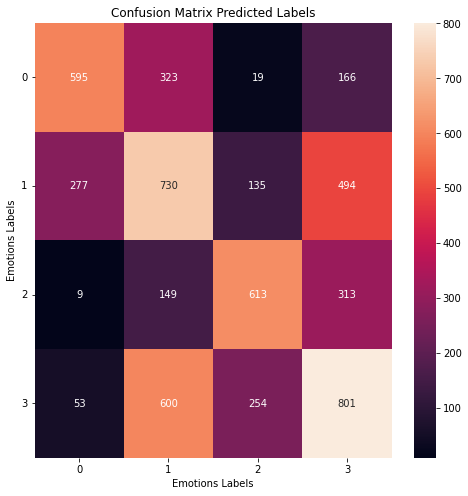

In [ ]:
plot_cm_predictions(RandomForest(random_state=1, max_features=None), data.values, categorical_labels)

#### Regression Problem (Valence, Activation, Dominance)

In [ ]:
model = RandomForestRegressor(random_state=1, max_features=None)
pred_values = cross_val_predict(model, data.values, regression_labels, cv=5, verbose=1, n_jobs=8)
print('MAE: %.3f' % metrics.mean_absolute_error(pred_values, regression_labels))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   21.7s remaining:   32.5s


MAE: 0.663


[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   22.2s finished


### Convolution Neural Networks
#### Categorical Problem (anger, happiness (+ excited), neutral, sadness)

In [ ]:
def build_model_0(input_shape=(24, 1), loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-5, epsilon=1e-6)):
    if loss.__class__ == SparseCategoricalCrossentropy().__class__:
        n_labels = 4
        metrics = ['accuracy']
        activation = 'softmax'
    else:
        n_labels = 3
        metrics = ['mae']
        activation = 'relu'

    model = Sequential()
    model.add(Conv1D(256, (5), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling1D(n_labels, strides=1))

    model.add(Conv1D(128, (5)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(n_labels))

    model.add(Activation(activation))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model
build_model_0(input_shape=(data.iloc[0].shape[0],1)).summary(show_trainable=True)

Model: "sequential"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 conv1d (Conv1D)             (None, 20, 256)           1536      Y          
                                                                            
 batch_normalization (BatchN  (None, 20, 256)          1024      Y          
 ormalization)                                                              
                                                                            
 activation (Activation)     (None, 20, 256)           0         Y          
                                                                            
 conv1d_1 (Conv1D)           (None, 16, 128)           163968    Y          
                                                                            
 activation_1 (Activation)   (None, 16, 128)           0         Y          
                                                        

In [ ]:
def categorical_cross_validation(callbacks, no_epochs, batch_size, loss, optimizer, verbosity, num_folds):
  print('------------------------------------------------------------------------')
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1
  
  X = df_soa.iloc[:,8:]
  y = df_soa.iloc[:,4:5]

  for train, test in kfold.split(X, y):
    model = build_model_0(input_shape=(data.shape[1], 1), loss=loss, optimizer=optimizer)
    
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    print(f'Training for fold {fold_no} ...')

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=callbacks,
                workers=4)

    scores = model.evaluate(X_test, y_test, verbose=verbosity)

    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

In [ ]:
callback = EarlyStopping(monitor='loss', patience=10)
no_epochs = 500 # try 300 or 700
batch_size = 16 # try 16
learning_rate=1e-5 # try 1e-4
loss = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=learning_rate)

verbosity = 0
num_folds = 5

categorical_cross_validation(callback, no_epochs, batch_size, loss, optimizer, verbosity, num_folds)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1.111961007118225; accuracy of 49.232158064842224%
Training for fold 2 ...
Score for fold 2: loss of 1.1252243518829346; accuracy of 48.73417615890503%
Training for fold 3 ...
Score for fold 3: loss of 1.1336780786514282; accuracy of 46.473780274391174%
Training for fold 4 ...
Score for fold 4: loss of 1.1383367776870728; accuracy of 46.383363008499146%
Training for fold 5 ...
Score for fold 5: loss of 1.1080365180969238; accuracy of 48.19168150424957%
------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 1.111961007118225 - Accuracy: 49.232158064842224%
> Fold 2 - Loss: 1.1252243518829346 - Accuracy: 48.73417615890503%
> Fold 3 - Loss: 1.1336780786514282 - Accuracy: 46.473780274391174%
> Fold 4 - Loss: 1.1383367776870728 - Accuracy: 46.383363008499146%
> Fold 5 - Loss: 1.1080365180969238 - Accuracy: 48.19168150424

#### Regression Problem (Valence, Activation, Dominance)

Note: Here Stratified K-Fold cannot be used because it has a continuous multi output label, so the distribution of emotions per fold is not going to be balanced.

Could use the categorical emotion to generate the folds and then use the regression labels

In [ ]:
def regression_cross_validation(callbacks, no_epochs, batch_size, loss, optimizer, verbosity, num_folds):
  print('------------------------------------------------------------------------')
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
  mae_per_fold = []
  loss_per_fold = []
  fold_no = 1
  
  X = df_soa.iloc[:,8:]
  y = df_soa.iloc[:,5:8]

  for train, test in kfold.split(X, y):
    model = build_model_0(input_shape=(data.shape[1], 1), loss=loss, optimizer=optimizer)
    
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    print(f'Training for fold {fold_no} ...')

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=callbacks,
                workers=4)

    scores = model.evaluate(X_test, y_test, verbose=verbosity)

    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    mae_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(mae_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - MAE: {mae_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> MAE: {np.mean(mae_per_fold)} (+- {np.std(mae_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

In [ ]:
callback = EarlyStopping(monitor='loss', patience=10)
no_epochs = 500 # try 300 or 700
batch_size = 32 # try 16
learning_rate=1e-5 # try 1e-5
loss = MeanAbsoluteError()
optimizer = Adam(learning_rate=learning_rate)

verbosity = 0
num_folds = 5

regression_cross_validation(callback, no_epochs, batch_size, loss, optimizer, verbosity, num_folds)

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.5870349407196045; mae of 58.70349407196045%
Training for fold 2 ...
Score for fold 2: loss of 0.615779459476471; mae of 61.577945947647095%
Training for fold 3 ...
Score for fold 3: loss of 0.5887221693992615; mae of 58.87221693992615%
Training for fold 4 ...
Score for fold 4: loss of 0.5906510353088379; mae of 59.06510353088379%
Training for fold 5 ...
Score for fold 5: loss of 0.6135765910148621; mae of 61.35765314102173%
------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 0.5870349407196045 - MAE: 58.70349407196045%
> Fold 2 - Loss: 0.615779459476471 - MAE: 61.577945947647095%
> Fold 3 - Loss: 0.5887221693992615 - MAE: 58.87221693992615%
> Fold 4 - Loss: 0.5906510353088379 - MAE: 59.06510353088379%
> Fold 5 - Loss: 0.6135765910148621 - MAE: 61.35765314102173%
-------------------------------------------------

## AutoKeras

In [ ]:
def categorical_cross_validation2(no_epochs, batch_size, loss, optimizer, verbosity, num_folds):
  print('------------------------------------------------------------------------')
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1
  
  X = df_soa.iloc[:,8:]
  y = df_soa.iloc[:,4:5]

  for train, test in kfold.split(X, y):
    model = ak.StructuredDataClassifier(overwrite=True, max_trials=100, seed=1, directory=f"best_regression_keras_model_fold_{fold_no}")
    
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    print(f'Training for fold {fold_no} ...')

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=no_epochs,
                verbose=verbosity,
                callbacks=[EarlyStopping()],
                workers=8)
  
    print(model.export_model().summary())


    scores = model.evaluate(X_test, y_test, verbose=verbosity)

    print(f'Score for fold {fold_no}: Loss of {scores[0]}; Accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

# classifier that tries 100 different keras classifier models
no_epochs = 500 # try 300 or 700
batch_size = 16 # try 16
learning_rate=1e-5 # try 1e-4
loss = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=learning_rate)

verbosity = 1
num_folds = 5

categorical_cross_validation2(no_epochs, batch_size, loss, optimizer, verbosity, num_folds)

Trial 84 Complete [00h 00m 03s]
val_accuracy: 0.13287514448165894

Best val_accuracy So Far: 0.743413507938385
Total elapsed time: 00h 05m 42s
INFO:tensorflow:Oracle triggered exit
Epoch 1/500
277/277 [==============================] - 1s 2ms/step - loss: 1.6184 - accuracy: 0.2493
Epoch 2/500
277/277 [==============================] - 1s 2ms/step - loss: 1.6064 - accuracy: 0.2522
Epoch 3/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5952 - accuracy: 0.2592
Epoch 4/500
277/277 [==============================] - 0s 2ms/step - loss: 1.5787 - accuracy: 0.2615
Epoch 5/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5554 - accuracy: 0.2712
Epoch 6/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5569 - accuracy: 0.2748
Epoch 7/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5372 - accuracy: 0.2843
Epoch 8/500
277/277 [==============================] - 1s 2ms/step - loss: 1.5279 - accuracy: 0.2800
Epoch 9/500

In [ ]:
def categorical_cross_validation3(batch_size, verbosity, num_folds):
  print('------------------------------------------------------------------------')
  kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1
  
  X = df_soa.iloc[:,8:]
  y = df_soa.iloc[:,4:5]

  for train, test in kfold.split(X, y):
    model = ak.StructuredDataClassifier(
        overwrite=True,
        tuner="bayesian",
        max_trials=100,
        seed=1,
        directory=f"best_regression_keras_model_3_fold_{fold_no}"
    )
    
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    print(f'Training for fold {fold_no} ...')

    history = model.fit(X_train, y_train,
                batch_size=batch_size,
                validation_data=(X_test, y_test),
                verbose=verbosity,
                callbacks=[EarlyStopping()],
                workers=8)
  
    print(model.export_model().summary())


    scores = model.evaluate(X_test, y_test, verbose=verbosity)

    print(f'Score for fold {fold_no}: Loss of {scores[0]}; Accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

batch_size = 16 # try 32, 64
verbosity = 0
num_folds = 5

categorical_cross_validation3(batch_size, verbosity, num_folds)

------------------------------------------------------------------------
Training for fold 1 ...
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: best_regression_keras_model_3_fold_1/structured_data_classifier/best_model/assets
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 24)               0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 24)               49        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1024)              25600     
       

FailedPreconditionError: ignored